# Statistics notebook: Shared States
Accompanying the manuscript: Oosterwijk, Snoek, Rotteveel, Barrett, & Scholte. (submitted). "Shared states: Using MVPA to test neural overlap between self-focused emotion imagery and other-focused emotion understanding."

Lukas Snoek, February 2016 | lukassnoek@gmail.com <br>
https://github.com/lukassnoek/SharedStates

### Code for main analysis
The code written for the main analysis (i.e. classification analysis of both the self-data and the generalization to the other-data) in contained in scripts hosted at the above Github repository, in the *main* folder. Importantly, the analyses use in-house MVPA analysis package *skbold* (https://github.com/lukassnoek/skbold), which needs to be installed to run the scripts (installation instructions are listed in the README on Github). Since the Shared States paper has been submitted, the skbold package has been developed further, rendering some of the code used for the paper's analyses deprecated. To install the package-version that is compatible with the analyses below, check out the **SharedStates** branch and install the package.



In [131]:
from __future__ import division, print_function
import cPickle
import os
import glob
import os.path as op
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.ndimage import label
import nibabel as nib
import pandas as pd
from copy import copy
from nilearn.plotting import plot_stat_map
from scipy.stats import f_oneway, ttest_rel, pearsonr, t
import seaborn as sns
from matplotlib.gridspec import GridSpec
from skbold.data2mvp import Fsl2mvp
%matplotlib inline
sns.set_style("ticks")

project_dir = '/media/lukas/data/SharedStates'
data_dir = op.join(project_dir, 'DATA', 'MVPA')
results_dir = op.join(project_dir, 'RESULTS', 'MVPA')
plot_dir = op.join(project_dir, 'ARTICLE', 'Plots')

The function below transforms 'raw' confusion matrics (in which the numbers indicate the number of trials assigned to a particular class, with the x-axis referring to the predicted class and the y-axis referring to the true class). The metrics precision (also known as Positive Predictive Value), recall (also known as the True Positive Rate), and F1-score (harmonic mean between precision and recall) are supported. In the article, precision-scores are reported.

# MAIN ARTICLE: STATISTICS & PLOTS
Below, the results from the validation set (as reported in the main article) are computed. The results from the optimization procedure and final analysis on the (final) optimization set are listed in section 2: SUPPLEMENTARY MATERIALS.

In [2]:
# Location of results from 100,000 iterations analysis
self_dir = op.join(results_dir, 'Validation/SELF/100000iter_results')
other_dir = op.join(results_dir, 'Validation/CROSS/100000iter_results')

## 1. Statistics of self-analysis
Below, we load in the subject-specific confusion matrices and convert the 'raw' metrics to more easily interpretable 'precision' scores:

$$ precision = \frac{true\ positives}{true\ positives + false\ positives} $$

The resulting ndarray thus contains precision-matrices for each subject, of which the average is plotted below.

In [3]:
self_files = glob.glob(op.join(self_dir, '*.pickle'))
s_confmat = np.zeros((len(self_files), 3, 3))
for i, f in enumerate(self_files):
    s_confmat[i, :, :] = cPickle.load(open(f)).conf_mat

# precision = confmat / sum over rows(confmat)
s_confmat /= s_confmat.sum(axis=1)[:, np.newaxis]
s_confmat[np.isnan(s_confmat)] = 0 # set NaNs (resulting from /0) to 0

### Figure 3 (main text)

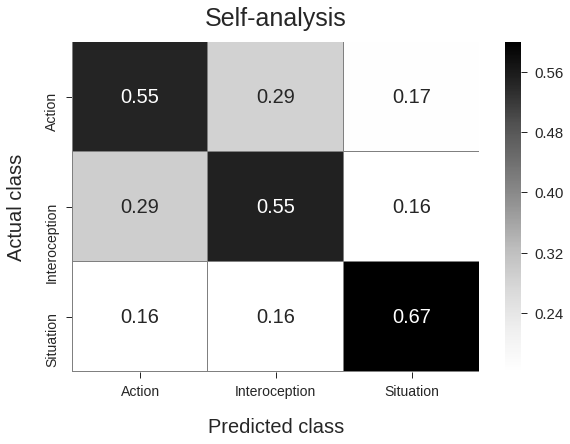

In [4]:
labels = ['Action', 'Interoception', 'Situation']
s_av_cm = s_confmat.mean(axis=0)
plt.figure(figsize=(8,6))
ax = sns.heatmap(s_av_cm, cmap=plt.cm.Greys, annot=True,
                 linewidths=0.1, linecolor='grey', vmax=.6, cbar=True, annot_kws={'fontsize': 20})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
plt.xticks(np.arange(3)+0.5, labels, fontsize=14)
plt.yticks(np.arange(3)+0.5, labels[::-1], fontsize=14)
plt.xlabel('Predicted class', fontsize=20, labelpad=19)
plt.ylabel('Actual class', fontsize=20, labelpad=19)
plt.title('Self-analysis', fontsize=25, y=1.03)
plt.tight_layout(pad=0.1)
plt.savefig(op.join(plot_dir, 'self_confmat.png'))

Below, we'll load in the confusion matrices from the permuted main analysis, which is exactly the same as the main analysis, yet with permuted class labels, yielding random models and corresponding confusion matrices. (This may take a while!)

In [5]:
# Loading in permutation confusion matrices
s_perm_dir = op.join(results_dir, 'Validation/SELF/permutation_results/')
s_dirs = glob.glob(op.join(s_perm_dir, 'perm_*'))
n = s_confmat.shape[0]

s_perm_mats = np.zeros((len(s_dirs), n, 3, 3))

for i, d in enumerate(s_dirs):
    mats = glob.glob(op.join(d, '*confmat.npy'))
    
    for ii, m in enumerate(mats):
        s_perm_mats[i, ii, :, :] = np.load(m)

# Calculate precision
s_perm_mats /= s_perm_mats.sum(axis=2)[:, :, :, np.newaxis]

In [6]:
# Significance: p-value = nr of perms above observed score / nr of total perms
# see: Nichols, T. E., & Holmes, A. P. (2002). Nonparametric permutation tests for functional neuroimaging: 
# a primer with examples. Human brain mapping, 15(1), 1-25

s_av_perm_mats = s_perm_mats.mean(axis=1) # average over subjects
s_p_cm = (s_confmat.mean(axis=0) < s_av_perm_mats).sum(axis=0) / s_av_perm_mats.shape[0]
print('Matrix with p-values per cell: \n\n%r' % np.round(s_p_cm, 4))

Matrix with p-values per cell: 

array([[ 0.    ,  0.9823,  1.    ],
       [ 0.9923,  0.    ,  1.    ],
       [ 1.    ,  1.    ,  0.    ]])


In [7]:
dperm = (s_confmat.mean(axis=0) - s_av_perm_mats.mean(axis=0)) / s_av_perm_mats.std(axis=0)
dsample = (s_confmat.mean(axis=0) - s_av_perm_mats.mean(axis=0)) / s_confmat.std(axis=0)

print(dperm)
print()
print(dsample)
print()
print(s_confmat.mean(axis=0))
print()
print(s_confmat.std(axis=0))

[[ 15.71052028  -2.00350686  -7.52002095]
 [ -2.49381887  15.82881351  -7.76596704]
 [ -7.56037555  -7.37719285  24.35136339]]

[[ 1.60457164 -0.48832906 -2.17960352]
 [-0.73834398  1.69370661 -2.95633191]
 [-2.183546   -2.61600782  2.88448502]]

[[ 0.54572425  0.28590883  0.16665278]
 [ 0.29229583  0.55078406  0.16307361]
 [ 0.16197992  0.1633071   0.6702736 ]]

[[ 0.13224942  0.09749913  0.08146899]
 [ 0.08152977  0.12853975  0.06500184]
 [ 0.08206882  0.06433846  0.11687691]]


## 2. Statistics of cross-analysis
Below, the same procedure as for the self-analysis is repeated.

In [8]:
other_files = glob.glob(op.join(other_dir, '*.pickle'))
o_confmat = np.zeros((len(other_files), 3, 3))
for i, f in enumerate(other_files):
    o_confmat[i, :, :] = cPickle.load(open(f)).conf_mat
    
o_confmat /= o_confmat.sum(axis=1)[:, np.newaxis]
o_confmat[np.isnan(o_confmat)] = 0

### Figure 3 (main text)

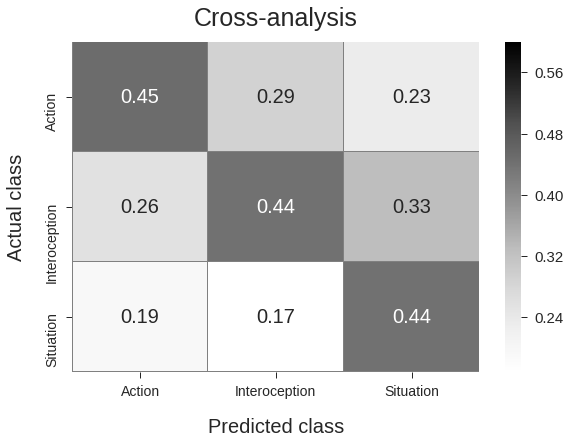

In [9]:
o_av_cm = np.mean(o_confmat, axis=0)
plt.figure(figsize=(8,6))
ax = sns.heatmap(o_av_cm, cmap=plt.cm.Greys, annot=True,
                 linewidths=0.1, linecolor='grey', vmax=.6, cbar=True, annot_kws={'fontsize': 20})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
plt.xticks(np.arange(3)+0.5, labels, fontsize=14)
plt.yticks(np.arange(3)+0.5, labels[::-1], fontsize=14)
plt.xlabel('Predicted class', fontsize=20, labelpad=19)
plt.ylabel('Actual class', fontsize=20, labelpad=19)
plt.title('Cross-analysis', fontsize=25, y=1.03)
plt.tight_layout(pad=0.1)
plt.savefig(op.join(plot_dir, 'cross_confmat.png'))

In [10]:
o_perm_dir = op.join(results_dir, 'Validation/CROSS/permutation_results/')
o_dirs = glob.glob(op.join(o_perm_dir, 'perm_*'))

# perm_mats shape = [nr perms, subjects, n_class, n_class]
o_perm_mats = np.zeros((len(o_dirs), o_confmat.shape[0], 3, 3))

for i, d in enumerate(o_dirs):
    mats = glob.glob(op.join(d, '*confmat.npy'))
    for ii, m in enumerate(mats):
        o_perm_mats[i, ii, :, :] = np.load(m)
        
o_perm_mats /= o_perm_mats.sum(axis=-2)[:, :, :, np.newaxis]

In [11]:
o_av_perm_mats = o_perm_mats.mean(axis=1)
o_p_cm = (o_confmat.mean(axis=0) < o_av_perm_mats).sum(axis=0) / o_av_perm_mats.shape[0]

print('Matrix with p-values per cell: \n\n%r' % np.round(o_p_cm, 4))

Matrix with p-values per cell: 

array([[ 0.    ,  0.9562,  1.    ],
       [ 1.    ,  0.    ,  0.9177],
       [ 1.    ,  1.    ,  0.    ]])


## 3. Visualizing classification model in voxel-space
Here, the process of creating 'voxel plots' in which model parameters (i.e. linear svm weights) are calculated and backprojected. The weights, here, are the average weights across cross-validation iterations, which
were subsequently averaged across subjects. Ideally, these mean weight values are normalized by, for example, their standard error, yielding a standard t-value map. However, as the averaged *absolute* weights are biased to be higher than 0, we cannot do a t-test with H<sub>0 </sub>= 0. Therefore, we ran the main analysis again, but now with permuted labels, to keep track of the model weights yielded by random models (i.e. the permuted_scores variable). These permuted weights are subsequently averaged the same way as the 'true' weights. Given this information, we now calculate the t-value map as:

$$ t-value = \frac{(average\ true\ weight - average\ permuted\ weight)}{standard\ deviation\ true\ weight /(n-1)} $$


For more information, check the *skbold* package at Github:
https://github.com/lukassnoek/skbold/blob/master/skbold/utils/mvp_utils.py.
The code to keep track of svm weights and subsequently how these are averaged across iterations and subjects is contained in the classes *MvpResults* and *MvpAverageResults* respectively.

In [12]:
vox_files = glob.glob(op.join(results_dir, 'Validation/true_feature_weights/vox_results_mni/*.nii.gz'))
perm_files = glob.glob(op.join(results_dir, 'Validation/random_feature_weights/vox_results_mni/*.nii.gz'))

vox_scores = np.zeros((len(vox_files), 91, 109, 91, 3))
perm_scores = np.zeros((len(perm_files), 91, 109, 91, 3))

for i, (v, p) in enumerate(zip(vox_files, perm_files)):
    perm_scores[i, :, :, :, :] = nib.load(p).get_data()
    vox_scores[i, :, :, :, :] = nib.load(v).get_data()

In [13]:
from skbold import roidata_path
mni = op.join(op.join(roidata_path, 'MNI152_2mm.nii.gz'))
affine = nib.load(mni).get_affine()

In [132]:
perm_average = np.abs(perm_scores).mean(axis=4)
vox_average = np.abs(vox_scores).mean(axis=4)
t_permuted = (vox_average.mean(axis=0) - perm_average.mean(axis=0)) / (vox_average.std(axis=0) / np.sqrt(n-1))
t_permuted[np.isnan(t_permuted)] = 0
t_permuted[np.isinf(t_permuted)] = 0
nib.save(nib.Nifti1Image(t_permuted, affine), op.join(plot_dir, 'modelweights'))

### Figure 4 (main text)
Below we plot the 't_permuted' image, but with a small 'cluster-correction' method applied, as one of reviewers noted that the plot was rather noisy-looking. As multivoxel patterns unlikely capitalize on very small clusters of voxels, even in whole-brain MVPA, given our smoothing kernel of 5mm, we agree with the reviewer that these 'noise-voxels' obscure the plot and are thus removed.

In [159]:
def cluster_size_threshold(data, thresh=None, min_size=20, save=False):
    """ Removes clusters smaller than a prespecified number in a stat-file.

    Parameters
    ----------
    data : numpy-array or str
        3D Numpy-array with statistic-value or a string to a path pointing to
        a nifti-file with statistic values.
    thresh : int, float
        Initial threshold to binarize the image and extract clusters.
    min_size : int
        Minimum size (i.e. amount of voxels) of cluster. Any cluster with fewer
        voxels than this amount is set to zero ('removed').
    save : bool
        If data is a file-path, this parameter determines whether the cluster-
        corrected file is saved to disk again.
    """

    if isinstance(data, (str, unicode)):
        fname = copy(data)
        data = nib.load(data)
        affine = data.affine
        data = data.get_data()

    if thresh is not None:
        data[data < thresh] = 0

    clustered, num_clust = label(data > 0)
    values, counts = np.unique(clustered.ravel(), return_counts=True)

    # Get number of clusters by finding the index of the first instance
    # when 'counts' is smaller than min_size
    first_clust = np.sort(counts)[::-1] < min_size
    if first_clust.sum() == 0:
        print('All clusters were larger than: %i, returning original data' % min_size)
        return data
    
    n_clust = np.argmax(first_clust)
    
    # Sort and trim
    cluster_nrs = values[counts.argsort()[::-1][:n_clust]]
    cluster_nrs = np.delete(cluster_nrs, 0)

    # Set small clusters to zero.
    data[np.invert(np.in1d(clustered, cluster_nrs)).reshape(data.shape)] = 0

    if save:
        img = nib.Nifti1Image(data, affine=affine)
        basename = op.basename(fname)
        nib.save(img, basename.split('.')[0] + '_thresholded.nii.gz')

    return data

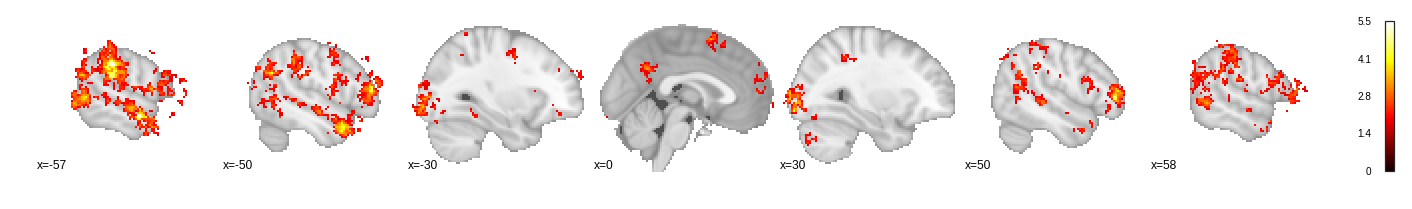

In [161]:
THRESH = 1.75
img = cluster_size_threshold(copy(t_permuted), 1.75, 20)
img = np.ma.array(img, mask=t_permuted < THRESH)
img = nib.Nifti1Image(img, affine)
nib.save(img, op.join(plot_dir, 'modelweights_th'))
weightsplot = plot_stat_map(img, display_mode='x', cut_coords=(-57, -50, -30, 0, 30, 50, 58),
                            vmax=5.5)
weightsplot.savefig(op.join(plot_dir, 'weightsplot'), dpi=600)

### Supplementary table 3
Please see the additional notebook ('Spatial configuration') for code how the tables are extracted (this is in a different notebook because it needs a different branch of the skbold-package).

# SUPPLEMENTARY MATERIALS
Below, the statistics, plots, and other supporting analyses for the manuscript's supplementary materials are calculated/performed.

**Note**: Details about the pilot study in which the stimuli for the self-focused task were developed (supplementary table 1) can be send upon request. Also, no code is available accompanying Supplementary Figure 2 (and its corresponding analyses), because these results were acquired with an old analysis pipeline implemented in MATLAB (and plotted in R).

## Supplementary figure 1: percentage of trials executed successfully
Also lists some code for descriptive statistics mentioned in the main article (e.g. demographics data).

In [3]:
# Some demographics
behav_datadir = op.join(project_dir, 'DATA', 'BEHAVIORAL')
demographics_file = op.join(behav_datadir, 'demographics.csv')
demogr = pd.read_csv(demographics_file, sep=',')

m_age = demogr['age'].mean()
std_age = demogr['age'].std()
number_female = np.sum([g == 'F' for g in demogr['gender']])
print('Mean age: %f, std age: %f' % (m_age, std_age))
print('Proportion female: %f' % number_female)

Mean age: 21.476190, std age: 1.749830
Proportion female: 14.000000


In [4]:
validation_file = op.join(behav_datadir, 'validation_behav.csv')
val_data = pd.read_csv(validation_file, sep=',')

# val_data is in 'wide' format, but for seaborn-style plots, we need a long format
vars_to_melt = ['suc_other_act', 'suc_other_int', 'suc_other_sit', 'suc_self_act', 'suc_self_int', 'suc_self_sit']
df_long = pd.melt(val_data, id_vars=['sub_name'], value_vars=vars_to_melt)
df_long['condition'] = ['self' if 'self' in c else 'other' for c in df_long['variable']]

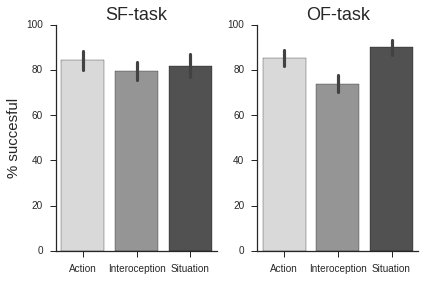

In [5]:
ax1 = plt.subplot(121)
sns.barplot(x='variable', y='value', data=df_long[df_long['condition']=='self'], palette='Greys')
ax1.set_ylabel('% succesful', fontsize=15), ax1.set_xlabel('')
ax1.set_xticklabels(['Action', 'Interoception', 'Situation'], fontsize=10)
ax1.set_title('SF-task', fontsize=18)
ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
sns.barplot(x='variable', y='value', data=df_long[df_long['condition']=='other'], palette='Greys')
ax2.set_ylabel(''), ax2.set_xlabel('')
ax2.set_xticklabels(['Action', 'Interoception', 'Situation'], fontsize=10)
ax2.set_title('OF-task', fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig(op.join(plot_dir, 'success.png'), dpi=800)

### Accompanying inferential statistics
Including a one-way ANOVA for testing the overall effect and follow-up pairwise comparisons.

In [64]:
n = val_data.shape[0]
k = 3 # i.e. 3 conditions (act, int, sit)
df1 = k - 1
df2 = n - k 

print('F-tests')
fval, pval = f_oneway(val_data['suc_self_act'], val_data['suc_self_int'], val_data['suc_self_sit'])
print('Self-data: F(%i, %i) = %f, p = %f' % (df1, df2, fval, pval))

fval, pval = f_oneway(val_data['suc_other_act'], val_data['suc_other_int'], val_data['suc_other_sit'])
print('Other-data: F(%i, %i) = %f, p = %f' % (df1, df2, fval, pval))

print('\nPairwise comparisons')
tval_si, pval_si = ttest_rel(val_data['suc_other_sit'], val_data['suc_other_int'])
print('Other sit-int: t(%i) = %f, p = %f)' % (n-1, tval_si, pval_si))

tval_sa, pval_sa = ttest_rel(val_data['suc_other_sit'], val_data['suc_other_act'])
print('Other sit-act: t(%i) = %f, p = %f)' % (n-1, tval_sa, pval_sa))

tval_ai, pval_ai = ttest_rel(val_data['suc_other_act'], val_data['suc_other_int'])
print('Other act-int: t(%i) = %f, p = %f)' % (n-1, tval_ai, pval_ai))
print('\nDescriptive statistics')

descr_stats = pd.DataFrame()
descr_stats['mean'] = val_data[['suc_other_act', 'suc_other_int', 'suc_other_sit']].mean()
descr_stats['se'] = val_data[['suc_other_act', 'suc_other_int', 'suc_other_sit']].std() / np.sqrt(n)
print(descr_stats)

F-tests
Self-data: F(2, 17) = 1.031114, p = 0.363164
Other-data: F(2, 17) = 17.740571, p = 0.000001

Pairwise comparisons
Other sit-int: t(19) = 6.838803, p = 0.000002)
Other sit-act: t(19) = 2.015114, p = 0.058264)
Other act-int: t(19) = 4.720808, p = 0.000149)

Descriptive statistics
               mean        se
suc_other_act  85.5  1.846048
suc_other_int  74.0  2.102630
suc_other_sit  90.0  1.919430


## Supplementary figure 4: Confusion matrices from optimization-set
Is analyzed/computed/visualized the same way as the confusion matrices from the validation-set. Note, however, that no permutation analysis was performed, so the p-values corresponding the confusion matrix cells were calculated using a regular one-sample t-test (against H<sub>0</sub>: 0.333)

In [17]:
# Location of results from 100,000 iterations analysis
optself_dir = op.join(results_dir, 'Optimization/SELF/Optimization_100000')
optother_dir = op.join(results_dir, 'Optimization/CROSS/Optimization_100000')

optself_files = glob.glob(op.join(optself_dir, '*.pickle'))
opts_confmat = np.zeros((len(optself_files), 3, 3))

for i, f in enumerate(optself_files): 
    opts_confmat[i, :, :] = cPickle.load(open(f)).conf_mat
    
opts_confmat /= opts_confmat.sum(axis=1)[:, np.newaxis]
opts_confmat[np.isnan(opts_confmat)] = 0

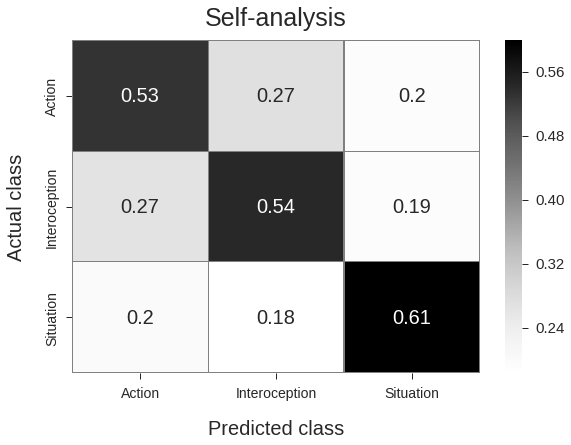

In [18]:
labels = ['Action', 'Interoception', 'Situation']
opts_av_cm = opts_confmat.mean(axis=0)
plt.figure(figsize=(8,6))
ax = sns.heatmap(opts_av_cm, cmap=plt.cm.Greys, annot=True,
                 linewidths=0.1, linecolor='grey', vmax=.6, cbar=True, annot_kws={'fontsize': 20})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
plt.xticks(np.arange(3)+0.5, labels, fontsize=14)
plt.yticks(np.arange(3)+0.5, labels[::-1], fontsize=14)
plt.xlabel('Predicted class', fontsize=20, labelpad=19)
plt.ylabel('Actual class', fontsize=20, labelpad=19)
plt.title('Self-analysis', fontsize=25, y=1.03)
plt.tight_layout(pad=0.1)
plt.savefig(op.join(plot_dir, 'optself_confmat.png'))

In [19]:
n = opts_confmat.shape[0]
tmat_self = (opts_confmat.mean(axis=0) - 0.333) / (opts_confmat.std(axis=0) / np.sqrt(n-1))
pmat_self = np.array([stats.t.sf(np.abs(tt), n-1)*2 for tt in tmat_self])
print(pmat_self.round(4))

[[ 0.      0.0164  0.    ]
 [ 0.0082  0.      0.    ]
 [ 0.      0.      0.    ]]


In [21]:
optother_files = glob.glob(op.join(optother_dir, '*.pickle'))
opto_confmat = np.zeros((len(optother_files), 3, 3))

for i, f in enumerate(optother_files):
    opto_confmat[i, :, :] = cPickle.load(open(f)).conf_mat

opto_confmat /= opto_confmat.sum(axis=1)[:, np.newaxis]
opto_confmat[np.isnan(opto_confmat)] = 0

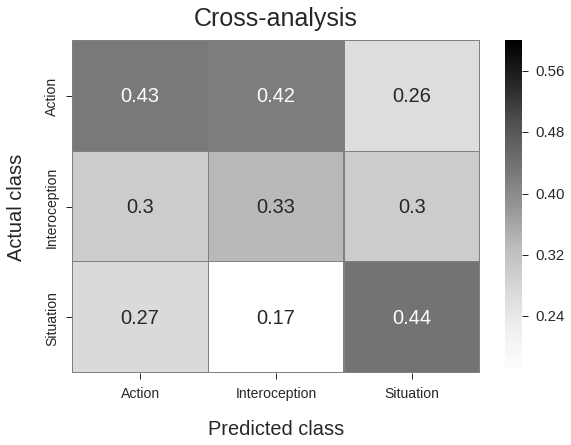

In [22]:
labels = ['Action', 'Interoception', 'Situation']
opto_av_cm = opto_confmat.mean(axis=0)
plt.figure(figsize=(8,6))
ax = sns.heatmap(opto_av_cm, cmap=plt.cm.Greys, annot=True,
                 linewidths=0.1, linecolor='grey', vmax=.6, cbar=True, annot_kws={'fontsize': 20})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
plt.xticks(np.arange(3)+0.5, labels, fontsize=14)
plt.yticks(np.arange(3)+0.5, labels[::-1], fontsize=14)
plt.xlabel('Predicted class', fontsize=20, labelpad=19)
plt.ylabel('Actual class', fontsize=20, labelpad=19)
plt.title('Cross-analysis', fontsize=25, y=1.03)
plt.tight_layout(pad=0.1)
plt.savefig(op.join(plot_dir, 'optother_confmat.png'))

### P-values for optimization confmat
No permutation-analysis was done for the optimization set, so reporting t-value statistics here.

In [23]:
n = opto_confmat.shape[0]
tmat_other = (opto_confmat.mean(axis=0) - 0.333) / (opto_confmat.std(axis=0) / np.sqrt(n-1))
pmat_other = np.array([stats.t.sf(np.abs(tt), n-1)*2 for tt in tmat_other])
print(pmat_other.round(3))

[[ 0.013  0.333  0.007]
 [ 0.171  0.981  0.057]
 [ 0.024  0.004  0.001]]


## Supplementary figure 6: relation self- and cross-scores & their distribution 
The plot below was included to show that, while precision scores between the self- and cross-analyses are uncorrelated, the distributions of scores from both analyses seem quite different. More specifically, the self-scores appear normally distributed, while the cross-scores appear to be have two 'peaks' in their distribution. In other words, there might be two groups of subjects: one which is capable of generalization from self to other and one group which is not (around chance level), which seems to be irrespective of their classification performance on the self-focused task. 

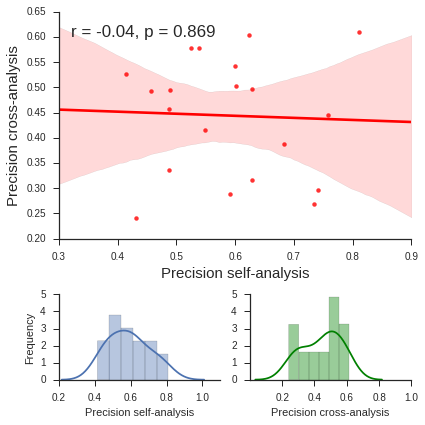

In [24]:
s_prec, c_prec = val_data.self_precision, val_data.cross_precision

gs = GridSpec(3, 2)

plt.figure(figsize=(6, 6))
sns.set_style('ticks')
plt.subplot(gs[0:2, 0:2])

sns.regplot(s_prec, c_prec, color='red')
r, p = pearsonr(s_prec, c_prec)
plt.text(0.32, 0.6, 'r = %.2f, p = %.3f' % (r, p), fontsize=17)
plt.xlabel('Precision self-analysis', fontsize=15)
plt.ylabel('Precision cross-analysis', fontsize=15)

plt.subplot(gs[2, 0])
sns.distplot(s_prec, bins=6)
plt.xlabel('Precision self-analysis')
plt.ylabel('Frequency')
plt.xticks(np.arange(0.2, 1.2, 0.2))
plt.yticks(np.arange(0, 6, 1))

plt.subplot(gs[2, 1])
sns.distplot(c_prec, bins=6, color='green')
plt.xlabel('Precision cross-analysis')
plt.xticks(np.arange(0.2, 1.2, 0.2))

sns.despine()
plt.tight_layout()#pad=3)
plt.savefig(op.join(plot_dir, 'self_cross_relation.png'), dpi=600)

## Supplementary figure 5: precision vs. recall

In [31]:
tmp_self = np.zeros((len(self_files), 3, 3))

for i, f in enumerate(self_files):
    tmp_self[i, :, :] = cPickle.load(open(f)).conf_mat
    
prec_self = tmp_self / tmp_self.sum(axis=1)[:, np.newaxis]
prec_self[np.isnan(prec_self)] = 0
recall_self = tmp_self / tmp_self.sum(axis=2)[:, :, np.newaxis]
recall_self[np.isnan(recall_self)] = 0
prec_self, recall_self = prec_self.mean(axis=0), recall_self.mean(axis=0)

tmp_other = np.zeros((len(other_files), 3, 3))

for i, f in enumerate(other_files):
    tmp_other[i, :, :] = cPickle.load(open(f)).conf_mat
    
prec_other = tmp_other / tmp_other.sum(axis=1)[:, np.newaxis]
prec_other[np.isnan(prec_other)] = 0
recall_other = tmp_other / tmp_other.sum(axis=2)[:, np.newaxis]
recall_other[np.isnan(recall_other)] = 0
prec_other, recall_other = prec_other.mean(axis=0), recall_other.mean(axis=0)

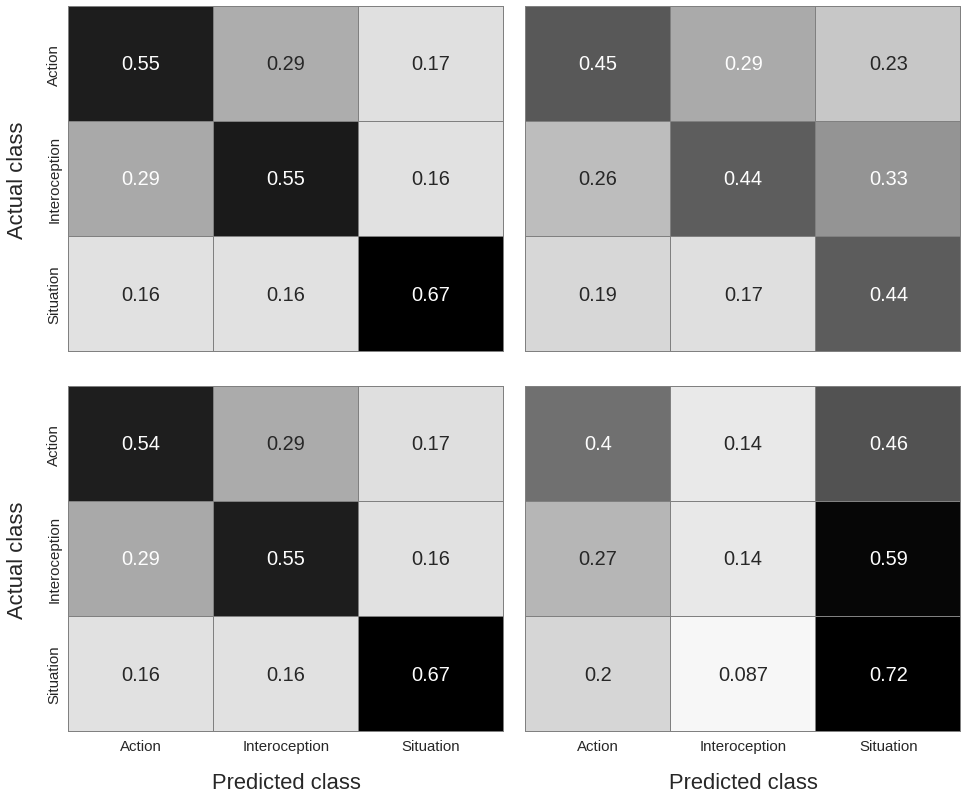

In [32]:
sns.set_style('white')
plt.figure(figsize=(16,13))
plt.subplots_adjust(hspace=0.1, wspace=0.05)

labels2 = ['A', 'I', 'S']
gs2 = GridSpec(2, 2)

plt.subplot(gs2[0, 0])

sns.heatmap(prec_self, cmap=plt.cm.Greys, annot=True, cbar=False,
            linewidths=0.2, linecolor='grey', vmax=.6, annot_kws={'fontsize': 20}, vmin=0.05)
plt.xticks(np.arange(3)+0.5, [''] * len(labels2))
plt.yticks(np.arange(3)+0.5, labels[::-1], fontsize=15)
plt.ylabel('Actual class', fontsize=22, labelpad=19)
#plt.title('Precision self-analysis', fontsize=18, y=1.05)

plt.subplot(gs2[0, 1])
sns.heatmap(prec_other, cmap=plt.cm.Greys, annot=True, cbar=False,
            linewidths=0.1, linecolor='grey', vmax=.6, annot_kws={'fontsize': 20}, vmin=0.05)
plt.xticks(np.arange(3)+0.5, [''] * len(labels2))
plt.yticks(np.arange(3)+0.5, [''] * len(labels2))
#plt.title('Precision cross-analysis', fontsize=18, y=1.05)

plt.subplot(gs2[1, 0])
sns.heatmap(recall_self, cmap=plt.cm.Greys, annot=True, cbar=False,
            linewidths=0.1, linecolor='grey', vmax=.6, annot_kws={'fontsize': 20}, vmin=0.05)
plt.xticks(np.arange(3)+0.5, labels, fontsize=15)
plt.yticks(np.arange(3)+0.5, labels[::-1], fontsize=15)
plt.xlabel('Predicted class', fontsize=22, labelpad=19)
plt.ylabel('Actual class', fontsize=22, labelpad=19)
#plt.title('Recall self-analysis', fontsize=18, y=1.05)

plt.subplot(gs2[1, 1])
sns.heatmap(recall_other, cmap=plt.cm.Greys, annot=True, cbar=False,
            linewidths=0.1, linecolor='grey', vmax=.6, annot_kws={'fontsize': 20}, vmin=0.05)
plt.xticks(np.arange(3)+0.5, labels, fontsize=15)
plt.yticks(np.arange(3)+0.5, [''] * len(labels2))
plt.xlabel('Predicted class', fontsize=22, labelpad=19)
#plt.title('Recall cross-analysis', fontsize=18, y=1.05)

plt.savefig(op.join(plot_dir, 'precision_recall_plots.png'), dpi=200)

### Statistics recall scores
No statistics have been computed for the recall scores (only precision for the main analysis).


In [34]:
# Loading in permutation confusion matrices
s_perm_dir = op.join(results_dir, 'Validation/SELF/permutation_results/')
s_dirs = glob.glob(op.join(s_perm_dir, 'perm_*'))
n = s_confmat.shape[0]

s_perm_mats = np.zeros((len(s_dirs), n, 3, 3))

for i, d in enumerate(s_dirs):
    mats = glob.glob(op.join(d, '*confmat.npy'))
    
    for ii, m in enumerate(mats):
        s_perm_mats[i, ii, :, :] = np.load(m)

# Calculate precision
s_perm_mats /= s_perm_mats.sum(axis=-1)[:, :, :, np.newaxis]

In [35]:
s_av_perm_mats = s_perm_mats.mean(axis=1) # average over subjects
s_p_cm = (recall_self < s_av_perm_mats).sum(axis=0) / s_av_perm_mats.shape[0]
print('Matrix with p-values per cell: \n\n%r' % np.round(s_p_cm, 4))

Matrix with p-values per cell: 

array([[ 0.    ,  0.9908,  1.    ],
       [ 0.9923,  0.    ,  1.    ],
       [ 1.    ,  1.    ,  0.    ]])


In [36]:
o_perm_dir = op.join(results_dir, 'Validation/CROSS/permutation_results/')
o_dirs = glob.glob(op.join(o_perm_dir, 'perm_*'))

# perm_mats shape = [nr perms, subjects, n_class, n_class]
o_perm_mats = np.zeros((len(o_dirs), o_confmat.shape[0], 3, 3))

for i, d in enumerate(o_dirs):
    mats = glob.glob(op.join(d, '*confmat.npy'))
    for ii, m in enumerate(mats):
        o_perm_mats[i, ii, :, :] = np.load(m)
        
o_perm_mats /= o_perm_mats.sum(axis=-1)[:, :, :, np.newaxis]

In [37]:
o_av_perm_mats = o_perm_mats.mean(axis=1) # average over subjects
o_p_cm = (recall_other < o_av_perm_mats).sum(axis=0) / o_av_perm_mats.shape[0]
print('Matrix with p-values per cell: \n\n%r' % np.round(o_p_cm, 4))

Matrix with p-values per cell: 

array([[ 0.0031,  1.    ,  0.    ],
       [ 0.9977,  1.    ,  0.    ],
       [ 1.    ,  1.    ,  0.    ]])
